In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv(r"C:\Downloads\archive (2)\NIFTY50_all.csv")
print("Dataset shape:", df.shape)

Dataset shape: (235192, 15)


In [3]:
print(df.head())

         Date      Symbol Series  Prev Close    Open     High    Low   Last  \
0  2007-11-27  MUNDRAPORT     EQ      440.00  770.00  1050.00  770.0  959.0   
1  2007-11-28  MUNDRAPORT     EQ      962.90  984.00   990.00  874.0  885.0   
2  2007-11-29  MUNDRAPORT     EQ      893.90  909.00   914.75  841.0  887.0   
3  2007-11-30  MUNDRAPORT     EQ      884.20  890.00   958.00  890.0  929.0   
4  2007-12-03  MUNDRAPORT     EQ      921.55  939.75   995.00  922.0  980.0   

    Close    VWAP    Volume      Turnover  Trades  Deliverable Volume  \
0  962.90  984.72  27294366  2.687719e+15     NaN           9859619.0   
1  893.90  941.38   4581338  4.312765e+14     NaN           1453278.0   
2  884.20  888.09   5124121  4.550658e+14     NaN           1069678.0   
3  921.55  929.17   4609762  4.283257e+14     NaN           1260913.0   
4  969.30  965.65   2977470  2.875200e+14     NaN            816123.0   

   %Deliverble  
0       0.3612  
1       0.3172  
2       0.2088  
3       0.2735  
4

In [4]:
company = "RELIANCE"
data = df[df['Symbol'] == company].copy()
print("Data filtered for:", company, "Shape:", data.shape)

Data filtered for: RELIANCE Shape: (5306, 15)


In [5]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

In [6]:
data = data[['Date', 'Close']]
data.set_index('Date', inplace=True)

In [7]:
dataset = data.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [8]:
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i+time_step, 0])
    return np.array(X), np.array(y)

In [10]:
time_step = 90
X, y = create_sequences(scaled_data, time_step)

In [11]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [12]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
print("Training size:", X_train.shape, "Testing size:", X_test.shape)

Training size: (4172, 90, 1) Testing size: (1043, 90, 1)


In [14]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 90, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 90, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 90, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [16]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/100
131/131 [==============================] - 37s 169ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 2/100
131/131 [==============================] - 23s 172ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 3/100
131/131 [==============================] - 19s 142ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 4/100
131/131 [==============================] - 31s 238ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 5/100
131/131 [==============================] - 22s 171ms/step - loss: 0.0013 - val_loss: 9.6057e-04
Epoch 6/100
131/131 [==============================] - 17s 131ms/step - loss: 0.0013 - val_loss: 7.5627e-04
Epoch 7/100
131/131 [==============================] - 24s 183ms/step - loss: 0.0012 - val_loss: 6.9671e-04
Epoch 8/100
131/131 [==============================] - 28s 211ms/step - loss: 0.0010 - val_loss: 7.1191e-04
Epoch 9/100
131/131 [==============================] - 27s 207ms/step - loss: 0.0011 - val_loss: 6.2048e-04
Epoch 10/100
131/131 [======================

In [17]:
y_pred = model.predict(X_test)

33/33 [==============================] - 5s 36ms/step


In [18]:
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

In [19]:
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

MSE: 1739.2759
RMSE: 41.7046


In [20]:
r2 = r2_score(y_test_actual, y_pred_actual)
print(f"R Square Score: {r2:.4f}")

R Square Score: 0.9884


In [21]:
accuracy_percent = r2 * 100
print(f"Model Accuracy: {accuracy_percent:.2f}%")

Model Accuracy: 98.84%


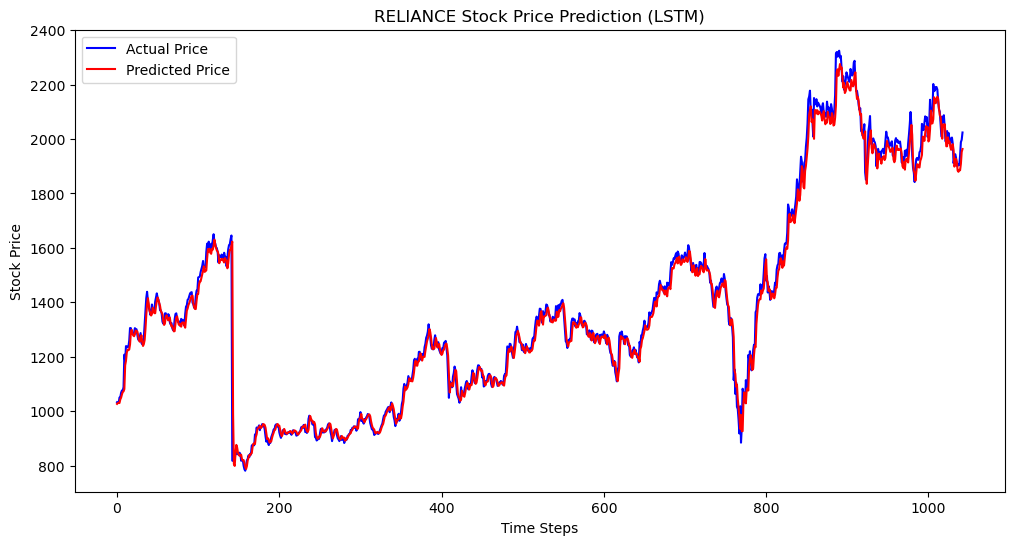

In [22]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, color='blue', label='Actual Price')
plt.plot(y_pred_actual, color='red', label='Predicted Price')
plt.title(f'{company} Stock Price Prediction (LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

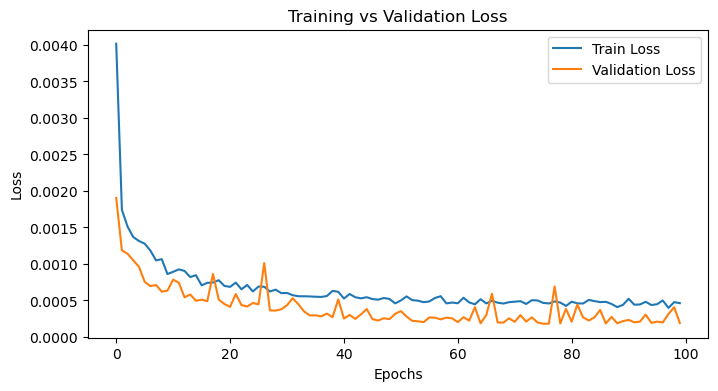

In [23]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.show()

In [24]:
last_90_days = scaled_data[-time_step:]
X_future = np.array([last_90_days])
X_future = X_future.reshape((X_future.shape[0], X_future.shape[1], 1))
future_price_scaled = model.predict(X_future)
future_price = scaler.inverse_transform(future_price_scaled)
print(f"\nPredicted next day closing price for {company}: {future_price[0][0]}")

1/1 [==============================] - 0s 69ms/step

Predicted next day closing price for RELIANCE: 1963.108642578125
